In [1]:
from pdb import run
from fff.simulation import run_calculator
from fff.simulation.utils import read_from_string, write_to_string
from _pytest.fixtures import fixture
import ase
from ase.build import molecule
from dataclasses import dataclass
from pathlib import Path
from typing  import Dict, Any, List, Optional
import os
import psutil
from functools import partial, update_wrapper
import json
import pickle
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
## data structures classes
@dataclass
class Trajectory:
    """Tracks the state of searching along individual trajectories

    We mark the starting point, the last point produced from sampling,
    and the last point we produced that has been validated
    """
    id: int  # ID number of the
    starting: ase.Atoms  # Starting point of the trajectory
    current_timestep = 0  # How many timesteps have been used so far
    last_validated: ase.Atoms = None  # Last validated point on the trajectory
    current: ase.Atoms = None  # Last point produced along the trajectory
    last_run_length: int = 0  # How long between current and last_validated
    name: str = None  # Name of the trajectory

    def __post_init__(self):
        self.last_validated = self.current = self.starting

    def update_current_structure(self, strc: ase.Atoms, run_length: int):
        """Update the structure that has yet to be updated

        Args:
            strc: Structure produced by sampling
            run_length: How many timesteps were performed in sampling run
        """
        self.current = strc.copy()
        self.last_run_length = run_length

    def set_validation(self, success: bool):
        """Set whether the trajectory was successfully validated

        Args:
            success: Whether the validation was successful
        """
        if success:
            self.last_validated = self.current  # Move the last validated forward
            self.current_timestep += self.last_run_length

@dataclass
class SimulationTask:
    atoms: ase.Atoms  # Structure to be run
    traj_id: int  # Which trajectory this came from
    ml_eng: float  # Energy predicted from machine learning model
    ml_std: Optional[float] = None  # Uncertainty of the model
    
@dataclass
class my_SimulationTask:
    simu_task: SimulationTask # basic information store in SimulationTask
    dft_energy: Optional[float] = None  # DFT energy of the structure
    dft_time: Optional[dict[int,float]] = None  # Dictionary to store DFT run times for different CPU cores
    temp_cores: Optional[int] = None  # Number of CPU cores used for the DFT calculation
    start_time: Optional[int] = None

In [28]:
# with open('./ga_simulation_test/task_queue_simulated_ga_test', 'rb') as f:
#     task_batch = pickle.load(f)

with open('./ga_simulation_test/task_queue_simulated_ga_test_8cores_per_task', 'rb') as f:
    task_batch = pickle.load(f)

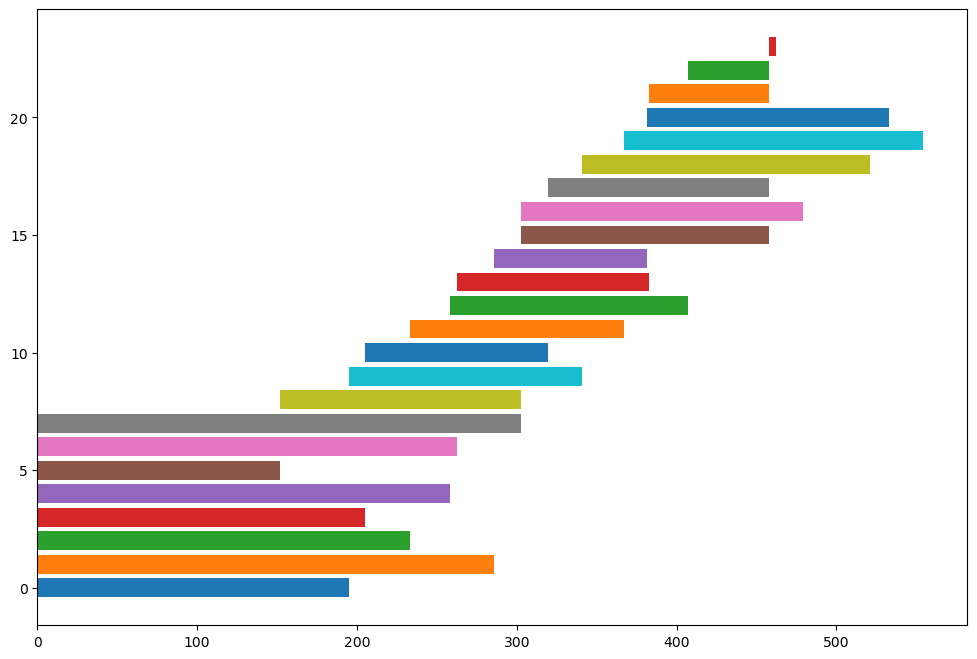

24
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [29]:
task_start_time = []
task_dft_time = []
task_cores = []
task_length = []
tottal_cores = 64
current_cores = 0
## sorted task_batch by start_time
task_batch = sorted(task_batch, key=lambda task: task.start_time)
for task in task_batch:
    # print(len(task.simu_task.atoms))
    # print(task.temp_cores)
    # print(task.dft_time)
    # print(task.start_time)
    task_start_time.append(task.start_time)
    task_dft_time.append(task.dft_time[task.temp_cores])
    task_cores.append(task.temp_cores)
    task_length.append(len(task.simu_task.atoms))
    
## barh
ss = min(task_start_time)
task_start_time = [x-ss for x in task_start_time]
fig, ax = plt.subplots(figsize=(12,8))
cnt = 0
for i in range(len(task_start_time)):
    # while (task_dft_time[cnt]+task_start_time[cnt]) < task_start_time[i]:
    #     current_cores -= task_cores[cnt]
    #     cnt += 1
    # ax.barh(current_cores, task_dft_time[i], left=task_start_time[i], height=task_cores[i])
    # current_cores += task_cores[i]
    ax.barh(i, task_dft_time[i], left=task_start_time[i])
plt.show()
print(len(task_start_time))
print(task_cores)

In [27]:
ga_sch = [{'name': 'simulation', 'task_id': 0, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 9, 'resources': {'cpu': 9}}, {'name': 'simulation', 'task_id': 10, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 20, 'resources': {'cpu': 6}}, {'name': 'simulation', 'task_id': 2, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 17, 'resources': {'cpu': 4}}, {'name': 'simulation', 'task_id': 23, 'resources': {'cpu': 6}}, {'name': 'simulation', 'task_id': 12, 'resources': {'cpu': 5}}, {'name': 'simulation', 'task_id': 8, 'resources': {'cpu': 8}}, {'name': 'simulation', 'task_id': 16, 'resources': {'cpu': 8}}, {'name': 'simulation', 'task_id': 18, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 11, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 19, 'resources': {'cpu': 6}}, {'name': 'simulation', 'task_id': 1, 'resources': {'cpu': 5}}, {'name': 'simulation', 'task_id': 13, 'resources': {'cpu': 4}}, {'name': 'simulation', 'task_id': 21, 'resources': {'cpu': 5}}, {'name': 'simulation', 'task_id': 6, 'resources': {'cpu': 11}}, {'name': 'simulation', 'task_id': 5, 'resources': {'cpu': 5}}, {'name': 'simulation', 'task_id': 7, 'resources': {'cpu': 10}}, {'name': 'simulation', 'task_id': 3, 'resources': {'cpu': 11}}, {'name': 'simulation', 'task_id': 14, 'resources': {'cpu': 7}}, {'name': 'simulation', 'task_id': 22, 'resources': {'cpu': 2}}, {'name': 'simulation', 'task_id': 15, 'resources': {'cpu': 2}}, {'name': 'simulation', 'task_id': 4, 'resources': {'cpu': 2}}]


    

0 7
9 9
10 7
20 6
2 7
17 4
23 6
12 5
8 8
16 8
18 7
11 7
19 6
1 5
13 4
21 5
6 11
5 5
7 10
3 11
14 7
22 2
15 2
4 2
